<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/bandit/battery_multi_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 乾電池の新・旧を見分ける
方法：乾電池を垂直に落として、新しい電池（しっかり立つもの）を探す
<br>[参考サイト](https://csoption.nifty.com/cs/denki/detail/160701000001/1.htm#:~:text=%E8%AA%BF%E3%81%B9%E3%81%9F%E3%81%84%E4%B9%BE%E9%9B%BB%E6%B1%A0%E3%82%92%E3%83%AA%E3%83%A2%E3%82%B3%E3%83%B3,%E6%8E%A8%E3%81%97%E9%87%8F%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%80%82)
-  マイナス面を下に垂直に落としたとき立つ確率は新しい電池ほど高いと仮定

In [ ]:
import copy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

# アーム（乾電池）の初期化を行う関数

In [ ]:
def _initialize_arms(arms_num):
    '''指定された本数分のサイズを持つarmsオブジェクトを返す
    Returns
    ------
    arms : list of dict (size: arms_num * dict_key_dim)
      2本の場合の例: [{TRIAL_NUM_KEY:0, OBS_REWARD_HISTORY_KEY:[], UCB_REWARD_HISTORY_KEY:[]}, 
                       {TRIAL_NUM_KEY:0, OBS_REWARD_HISTORY_KEY:[], UCB_REWARD_HISTORY_KEY:[]}]
    '''
    arm = {TRIAL_NUM_KEY:0, OBS_REWARD_HISTORY_KEY:[], UCB_REWARD_HISTORY_KEY:[]}
    arms = [copy.deepcopy(arm) for _ in np.arange(arms_num)]
    return arms

##報酬を観測する関数

In [ ]:
def _observe_reward(proba):
    '''電池が立ったとき、報酬獲得'''
    return 1 if np.random.random() <= proba else 0

##観測結果から期待値とその上界を計算する関数
- UCB-1:Upper Confidence Bound
$$ \bar{X}_{UCB-1,j}=\bar{X}_{j}+\sqrt{2*\frac{InN}{N_{j}}}$$
$$ \bar{X}_{j}:j番目のアームが観測してきた報酬から算出する平均値（期待値）$$
$$N_{j}:j番目のアームが選ばれた回数, Nは全アームが選ばれた総回数$$
$$同じアームを引き続けるとN_{j}が大きくなるため信頼区間が小さくなる.$$
$$一方、引かれていないアームについてはN_{j}が小さくなるため信頼区間は大きく見積もられる.$$

In [ ]:
TRIAL_NUM_KEY = "trial_num"
OBS_REWARD_HISTORY_KEY = "observed_reward_history"
UCB_REWARD_HISTORY_KEY = "ucb_reward_hisotry"


def _take_arms_trial_and_recent_reward(arms):
    '''各アームの試行回数配列、観測結果配列、期待値のUCB配列を返す

    Returns
    -----
    arms_trial : 各アームの試行回数配列
    arms_obs_reward : 各アームの観測結果配列
    arms_ucb_reward : 各アームのucb結果配列
    '''
    arm_num = len(arms)
    arms_trial = np.empty(arm_num)
    arms_obs_reward = []
    arms_ucb_reward = np.empty(arm_num)

    for i, arm_info in enumerate(arms):
        arm_trial = arm_info[TRIAL_NUM_KEY]
        arm_obs_reward = arm_info[OBS_REWARD_HISTORY_KEY]
        arm_recent_ucb_reward = arm_info[UCB_REWARD_HISTORY_KEY][-1] if len(arm_info[UCB_REWARD_HISTORY_KEY])!=0 else 0
        arms_trial[i] = arm_trial
        arms_obs_reward.insert(i, arm_obs_reward)
        arms_ucb_reward[i] = arm_recent_ucb_reward
    
    return arms_trial, arms_obs_reward, arms_ucb_reward


def _calc_ucb(arms, total_trial, delta=0.01):
    '''期待値の上界を計算
    
    Parameters
    -----
    arms : dict
    total_trial : 試行回数
    delta : 0除算を避ける用途の微小な値

    Returns
    -----
    new_arms_ucb_reward : 各アームの期待値(上界)
    '''
    arms_trial, arms_obs_reward, _ = _take_arms_trial_and_recent_reward(arms)
    
    arm_num = len(arms_trial)
    new_arms_ucb_reward = np.empty(arm_num)

    for i, (trial_num, obs_reward) in enumerate(zip(arms_trial, arms_obs_reward)):
        
        # 観測結果から期待値の計算
        mean_reward = 0 if trial_num == 0 else np.mean(obs_reward)
        
        # 正則化項の計算
        regularization = np.sqrt(2*np.log(total_trial)/(trial_num+delta))

        # 期待値と正則化項の情報から期待値の上界を計算
        new_reward_ucb = mean_reward + regularization
        # 観測された期待値と上界の変化を見たい場合は、コメントアウト外してください 
        #print('{} + {} = {}'.format(mean_reward, regularization, new_reward_ucb))

        new_arms_ucb_reward[i] = new_reward_ucb

    return new_arms_ucb_reward


def _update_ucb_reward(arms, total_trial):
    '''期待値の上界を計算し、結果を挿入
    WARNING: 破壊的操作'''
    arms_trial, _, arms_ucb_reward = _take_arms_trial_and_recent_reward(arms)
    
    if arms_trial.sum() != total_trial:
        raise Exception("現在の試行回数と、各アームの試行回数の合計が一致しません！")

    new_ucb_rewards = _calc_ucb(arms, total_trial, delta=0.01)
    
    for new_ucb_reward, arm_info in zip(new_ucb_rewards, arms):
        # 新しい期待値の上界を挿入
        ucb_reward_history = arm_info[UCB_REWARD_HISTORY_KEY]
        ucb_reward_history.append(new_ucb_reward)

##電池を1つ選択する関数
- 期待値の一番高い電池を選択(UCB-1の方策)
$$行動a=j～argmax(\bar{X}_{UCB-1,j=1,2,3,,})$$

In [ ]:
def _choice_argmax_reward_arm(arms):
    '''期待値が一番高いarmを選択
    選択されたarmの試行回数を1増やす
    INFO : 最大値の要素が複数存在する場合、最初に出現する最大値の要素を選択

    Returns
    -----
    choice_index : 選択されたarmのインデックス
    choiced_arms : 選択されたarmの試行回数が1加算されたarms
    '''
    arms_trial, _, arms_ucb_reward = _take_arms_trial_and_recent_reward(arms)
    
    if arms_trial.sum() == 0:
        # 初回実行時はアームをランダムに選択
        choice_index = np.random.randint(0, len(arms))
    else:
        choice_index = np.argmax(arms_ucb_reward)
    
    choiced_arms = arms.copy()
    choiced_arms[choice_index][TRIAL_NUM_KEY] = choiced_arms[choice_index][TRIAL_NUM_KEY] + 1
    
    return choice_index, choiced_arms    

## 一連の試行を行う関数

In [ ]:
def multi_bandit(arms_num, max_trial, true_probas=None):
    '''最適化椀を探索 & 活用する
    
    Parameters
    -----
    arms_num : int
      アームの本数
    max_trial : int
      試行回数
    true_probas : like ndarray(default:None)
      アームが結果を返す真の確率
      default値の場合、アームの数だけ0～1の乱数を真の確率として設定

    Returns
    -----
    final_arms_state : dict
      全試行が終了した後のアームの状態
    choice_history : ndarray(int)
      各試行時でのアームの選択結果
    true_probas : like ndarry
      各アームが報酬を出力する真の確率
    '''
    if true_probas is None:
        true_probas = np.random.random(len(arms_num))
    
    def _is_size_matched():
        return len(true_probas) == arms_num
    
    if not _is_size_matched():
       raise Exception("arms_num and true_probas are not match size!")

    arms = _initialize_arms(arms_num)
    choice_history = np.ndarray(0)
    final_arms_state = copy.deepcopy(arms)
    
    for i in np.arange(max_trial):
        # アームを選択
        choice_index, choiced_arms_state = _choice_argmax_reward_arm(final_arms_state)
        choice_history = np.append(choice_history, choice_index)

        # アーム選択後の報酬の値を観測
        obs_reward = _observe_reward(true_probas[choice_index])
        observed_arms_state = choiced_arms_state
        observed_arms_state[choice_index][OBS_REWARD_HISTORY_KEY].append(obs_reward)

        # 観測された報酬の値から、各アームのUCB(期待値の上限値) を算出
        _update_ucb_reward(observed_arms_state, i+1)

        final_arms_state = observed_arms_state
    

    def _take_mean_reward():
        '''試行で観測された報酬から各アームの期待値を算出して、取り出す
        INFO: モデルが各アームの期待値を予測しながらアームの選択を行っているため、
              モデルが観測した各アームの平均値と、真の確率が比較可能と考えられる可能性がある
        '''
        arms_observed_mean_reward = np.ndarray(0)
        for i, arm in enumerate(final_arms_state):
            arm_observed_mean_reward = np.array(arm[OBS_REWARD_HISTORY_KEY]).mean() if len(arm[OBS_REWARD_HISTORY_KEY]) !=0 else 0
            arms_observed_mean_reward = np.append(arms_observed_mean_reward, arm_observed_mean_reward)
        
        return arms_observed_mean_reward


    estimated_probas = _take_mean_reward()

    return final_arms_state, choice_history, estimated_probas, true_probas


## 問題の設定とバンディットアルゴリズムの実行（パラメータ設定は主に、ここを編集してください）

In [ ]:
%%time
# 電池の本数
battery_num = 6

# 電池が垂直に立つ真の確率を設定（今回の予測のキーポイントとなる確率）
# マイナス面を下に垂直に落としたとき立つ確率は、新しい電池ほど高い
battery_proba = [0.1, 0.2, 0.4, 0.6, 0.7, 0.1]

# 探索&活用回数
trial_num = 60 #@param{type:'number'}


# 探索&活用の実行
final_arms_state, choice_history, estimated_probas, true_probas = multi_bandit(arms_num=battery_num, max_trial=trial_num,
                                                             true_probas=battery_proba)

arm_trials = [arms_info[TRIAL_NUM_KEY] for arms_info in final_arms_state]

# 結果の配列描画
print("各電池の試行回数 : {}".format(arm_trials))
print("各電池が立つの真の確率 : {}".format(true_probas))
print("各電池が立つ確率の予測値(観測値から期待値を算出) : {}".format(estimated_probas))
print("最後らへんに選択されているアームのインデックス : {}".format(choice_history[-20:]))

各電池の試行回数 : [6, 10, 6, 12, 21, 5]
各電池が立つの真の確率 : [0.1, 0.2, 0.4, 0.6, 0.7, 0.1]
各電池が立つ確率の予測値(観測値から期待値を算出) : [0.16666667 0.4        0.16666667 0.5        0.66666667 0.        ]
最後らへんに選択されているアームのインデックス : [3. 4. 4. 4. 1. 1. 1. 4. 4. 0. 2. 5. 3. 4. 4. 4. 4. 1. 4. 4.]
CPU times: user 23.2 ms, sys: 19 µs, total: 23.2 ms
Wall time: 22.9 ms


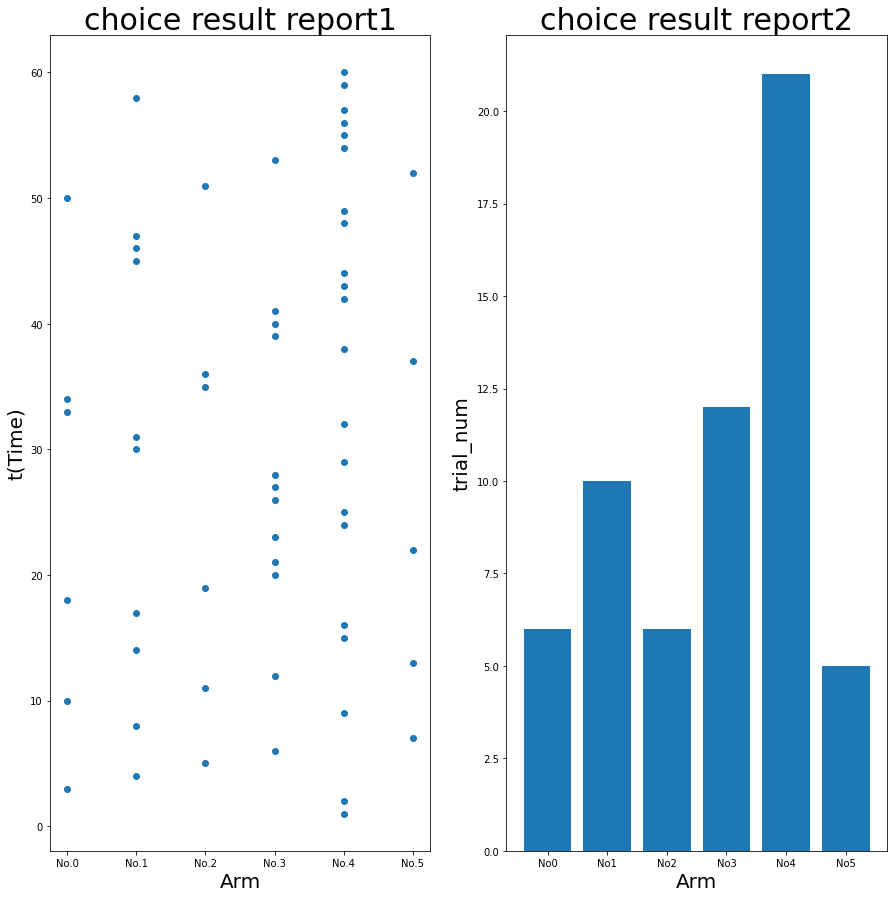

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))

title_font_size = 30
label_font_size = 20

y=np.arange(1, len(choice_history)+1)
axes[0].scatter(x=choice_history, y=y)

axes[0].set_title('choice result report1', fontsize=title_font_size)
axes[0].set_xlabel('Arm', fontsize=label_font_size)
axes[0].set_ylabel('t(Time)', fontsize=label_font_size)
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: 'No.'+str(int(x)) if x == int(x) else ''))


x_vals = [x for x in np.arange(battery_num)]
xlabels = ['No'+str(x) for x in x_vals]
axes[1].bar(x=x_vals, height=arm_trials, tick_label=xlabels)

axes[1].set_title('choice result report2', fontsize=title_font_size)
axes[1].set_xlabel('Arm', fontsize=label_font_size)
axes[1].set_ylabel('trial_num', fontsize=label_font_size)

plt.show()